In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Importing the Dataset 
- Load in the data from `fabricated_data`

In [110]:
import pathlib

# Load in the spectrograms from the fabricated data directory
data_dir = '../fabricated_data'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count) # Number of images in our dataset


26000


In [111]:
# View the first image of scope 0
scope_0 = list(data_dir.glob('0/*'))
PIL.Image.open(str(scope_0[1]))

IndexError: list index out of range

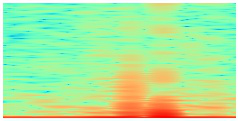

In [ ]:
# View the first image of scope 1
scope_1 = list(data_dir.glob('1/*'))
PIL.Image.open(str(scope_1[1]))

# Creating a dataset


In [ ]:

batch_size = 32
img_height = 121
img_width = 238

## Splitting dataset into two

- One for training and one for validating
- It will be split in the ratio 80% testing, 20% validating

In [ ]:
# Training dataset will take 80% of data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26200 files belonging to 26 classes.
Using 20960 files for training.


In [112]:
# Validating dataset will take 20% of data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26200 files belonging to 26 classes.
Using 5240 files for validation.


## Class Names

- These correspond to the directory names in alphabetical order.

In [113]:
# Class names refer to the categories our model will predict
class_names = train_ds.class_names
print(class_names)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


## Visualise our data

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

sns.set(style='whitegrid')
sns.axes_style('white')
sns.set_context("paper", font_scale=1.25, rc={"lines.linewidth": 2})
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 12})
rcParams['font.family'] = 'Avenir'

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

The image_batch is a tensor of the shape (32, 1215, 2385, 3). This is a batch of 32 images of shape 1215x2385x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 121, 238, 3)
(32,)


In [115]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardise the Data

- RGB is given a value between 0 and 255, we instead want something in the range of [0,1] so we will simply divide all RGB values by 255

In [116]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Create the Model


In [118]:
num_classes = 26

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [119]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 121, 238, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 121, 238, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 60, 119, 16)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 60, 119, 32)       4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 59, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 30, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 29, 64)      

# Training the Model

In [121]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

655/655 [==============================] - 456s 613ms/step - loss: 0.5191 - accuracy: 0.8468 - val_loss: 0.1061 - val_accuracy: 0.9643


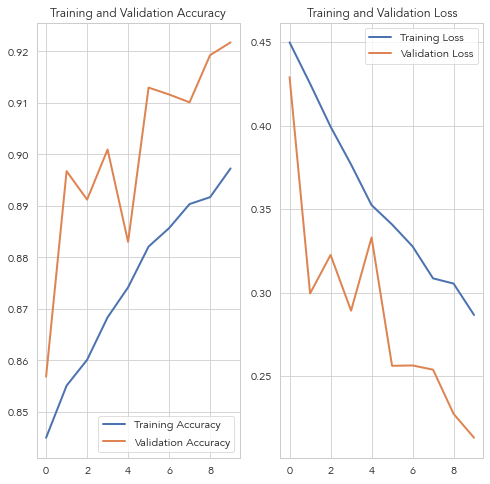

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [123]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [124]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [125]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 121, 238, 3)       0         
_________________________________________________________________
rescaling_13 (Rescaling)     (None, 121, 238, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 121, 238, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 60, 119, 16)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 119, 32)       4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 59, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 59, 64)      

In [139]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
655/655 [==============================] - 489s 747ms/step - loss: 0.4497 - accuracy: 0.8450 - val_loss: 0.4289 - val_accuracy: 0.8569
Epoch 2/10
655/655 [==============================] - 440s 672ms/step - loss: 0.4250 - accuracy: 0.8551 - val_loss: 0.2996 - val_accuracy: 0.8968
Epoch 3/10
655/655 [==============================] - 443s 675ms/step - loss: 0.3993 - accuracy: 0.8601 - val_loss: 0.3226 - val_accuracy: 0.8912
Epoch 4/10
655/655 [==============================] - 384s 586ms/step - loss: 0.3767 - accuracy: 0.8684 - val_loss: 0.2893 - val_accuracy: 0.9010
Epoch 5/10
655/655 [==============================] - 403s 616ms/step - loss: 0.3524 - accuracy: 0.8742 - val_loss: 0.3331 - val_accuracy: 0.8830
Epoch 6/10
655/655 [==============================] - 391s 597ms/step - loss: 0.3408 - accuracy: 0.8821 - val_loss: 0.2563 - val_accuracy: 0.9130
Epoch 7/10
655/655 [==============================] - 364s 556ms/step - loss: 0.3277 - accuracy: 0.8857 - val_loss: 0.2565 -

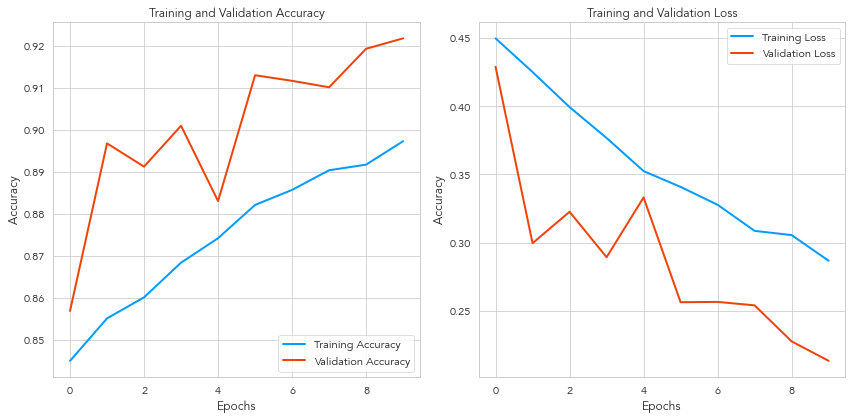

In [185]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color= "#029BFF")
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color="#EF4407")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color= "#029BFF")
plt.plot(epochs_range, val_loss, label='Validation Loss', color="#EF4407")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
image_path = "../docs/cnn_validation.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight', transparent=False)

In [168]:


img = keras.preprocessing.image.load_img('test_data_for_cnn/test_4.jpg'
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 04 with a 95.07 percent confidence.
